In [1]:
import os
import h5py
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.interpolate import griddata

import json

# from matplotlib import widgets
#Stackreg Regstrations
#https://pypi.org/project/pystackreg/
from pystackreg import StackReg

#Phase cross correlation
from skimage import data
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift
from scipy.ndimage import fourier_shift
from skimage.registration._phase_cross_correlation import _upsampled_dft

import scipy.ndimage as ndi

from ipywidgets import interact, widgets

from skimage import filters
from skimage import morphology
from skimage.segmentation import watershed

C:\Users\yamamoto\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Functions

In [2]:
def low_pass_filter(signal, cutoff_freq, sample_rate):
    """
    Apply a low-pass filter to a 1D signal to remove high-frequency noise.

    Parameters:
        signal (numpy.ndarray): The input 1D signal.
        cutoff_freq (float): The cutoff frequency for the low-pass filter (in Hz).
        sample_rate (float): The sample rate of the signal (in Hz).

    Returns:
        numpy.ndarray: The filtered signal.
    """
    # Perform FFT on the signal
    freq_domain = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), d=1/sample_rate)
    
    # Create a mask for frequencies below the cutoff frequency
    low_pass_mask = np.abs(freqs) <= cutoff_freq
    
    # Apply the mask to the frequency domain
    filtered_freq_domain = freq_domain * low_pass_mask
    
    # Perform the inverse FFT to get back to the time domain
    filtered_signal = np.fft.ifft(filtered_freq_domain).real
    
    return filtered_signal

from scipy.signal import savgol_filter

def smooth_signal(signal, window_length, polyorder):
    """
    Smooth a 1D signal using the Savitzky-Golay filter to reduce high-frequency noise.
    This filter minimizes edge effects by fitting a local polynomial.

    Parameters:
        signal (numpy.ndarray): The input 1D signal.
        window_length (int): The length of the filter window (must be odd and > polyorder).
        polyorder (int): The order of the polynomial used to fit the samples.

    Returns:
        numpy.ndarray: The smoothed signal.
    """
    # Ensure window_length is odd and greater than polyorder
    if window_length % 2 == 0:
        window_length += 1
    
    # Apply the Savitzky-Golay filter
    smoothed_signal = savgol_filter(signal, window_length=window_length, polyorder=polyorder)
    return smoothed_signal

# Energy

In [3]:
energy = []

ene1 = np.arange(630.0, 638.5, 0.5)
ene2 = np.arange(638.5, 644.5, 0.05)
ene3 = np.arange(644.5, 650.0, 0.5)
ene4 = np.arange(650.0, 656.0, 0.1)
ene5 = np.arange(656.0, 662.5, 0.5)

energy = np.concatenate((ene1, ene2, ene3, ene4, ene5))

print(energy)
print(len(energy))

[630.   630.5  631.   631.5  632.   632.5  633.   633.5  634.   634.5
 635.   635.5  636.   636.5  637.   637.5  638.   638.5  638.55 638.6
 638.65 638.7  638.75 638.8  638.85 638.9  638.95 639.   639.05 639.1
 639.15 639.2  639.25 639.3  639.35 639.4  639.45 639.5  639.55 639.6
 639.65 639.7  639.75 639.8  639.85 639.9  639.95 640.   640.05 640.1
 640.15 640.2  640.25 640.3  640.35 640.4  640.45 640.5  640.55 640.6
 640.65 640.7  640.75 640.8  640.85 640.9  640.95 641.   641.05 641.1
 641.15 641.2  641.25 641.3  641.35 641.4  641.45 641.5  641.55 641.6
 641.65 641.7  641.75 641.8  641.85 641.9  641.95 642.   642.05 642.1
 642.15 642.2  642.25 642.3  642.35 642.4  642.45 642.5  642.55 642.6
 642.65 642.7  642.75 642.8  642.85 642.9  642.95 643.   643.05 643.1
 643.15 643.2  643.25 643.3  643.35 643.4  643.45 643.5  643.55 643.6
 643.65 643.7  643.75 643.8  643.85 643.9  643.95 644.   644.05 644.1
 644.15 644.2  644.25 644.3  644.35 644.4  644.45 644.5  645.   645.5
 646.   646.5  647. 

# Load data

In [4]:
date = '2025-01-30'
imageNumber_lcp = '093' # C+
imageNumber_rcp = '094' # C-
entryNumber = 'entry1'

interpolation = 'linear' ## 'cubic'
detector = 'APD' ## available detectors 'APD', 'timemachine', 'PMT', 'VCO'
root_path = ''

# Check if image exists
image_path_lcp = (os.path.normpath(os.path.join(root_path, 'Sample_Line_'+date+'_'+imageNumber_lcp+'.hdf5')))
print(image_path_lcp)

if not os.path.exists(image_path_lcp):
    raise Exception("Image of LCP does not exist")


image_path_rcp = (os.path.normpath(os.path.join(root_path, 'Sample_Line_'+date+'_'+imageNumber_rcp+'.hdf5')))
print(image_path_rcp)

if not os.path.exists(image_path_rcp):
    raise Exception("Image of RCP does not exist")

# Loading and processing the LCP data
datasetDet = '/'+entryNumber+'/'+detector
datasetInst = '/'+entryNumber+'/instrument'
datasetColl = '/'+entryNumber+'/collection'
datasetCont = '/'+entryNumber+'/control'

C:\Users\yamamoto\Dropbox\MPI\Project\MnTe\Beamtime\BESSY_MAXYMUS_Jan2025\Data\Sample_Line_2025-01-30_093.hdf5
C:\Users\yamamoto\Dropbox\MPI\Project\MnTe\Beamtime\BESSY_MAXYMUS_Jan2025\Data\Sample_Line_2025-01-30_094.hdf5


In [5]:
with h5py.File(image_path_lcp,'r') as f:
    
    # Experimental conditions
    # energy = np.array(f[datasetDet+'/energy'][0])
    energy = np.array(f[datasetCont+'/energy'])
    magneticField = np.array(f[datasetColl+'/magnetic_field/value'][0])
    
    scanRequest = np.array(f[datasetColl+'/scan_request/scan_request'])
    scanRequeststr = scanRequest[0].decode("utf-8")
    scanRequestdecoded = json.loads(scanRequeststr)

    innerRegions = scanRequestdecoded['innerRegions']
    
    I_lcp = f[datasetDet+'/data'][()]
    
with h5py.File(image_path_rcp,'r') as f:
    
    # Experimental conditions
    # energy = np.array(f[datasetDet+'/energy'][0])
    energy = np.array(f[datasetCont+'/energy'])
    magneticField = np.array(f[datasetColl+'/magnetic_field/value'][0])
    
    scanRequest = np.array(f[datasetColl+'/scan_request/scan_request'])
    scanRequeststr = scanRequest[0].decode("utf-8")
    scanRequestdecoded = json.loads(scanRequeststr)

    innerRegbions = scanRequestdecoded['innerRegions']
    
    I_rcp = f[datasetDet+'/data'][()]    

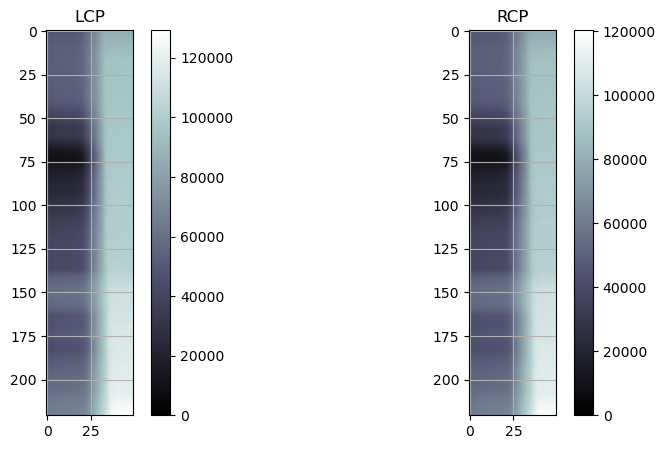

In [6]:
fig,(ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

#
im1=ax1.imshow(I_lcp, cmap='bone', vmin=0)#,vmax=0.1)
ax1.set_title('LCP')
plt.colorbar(im1,ax=ax1)
ax1.grid()
#
im2=ax2.imshow(I_rcp, cmap='bone', vmin=0)#,vmax=0.1)
ax2.set_title('RCP')
plt.colorbar(im2,ax=ax2)
ax2.grid()

# Subtract offset

### Setting offset manually

630.0
639.0
641.0
643.0
662.0


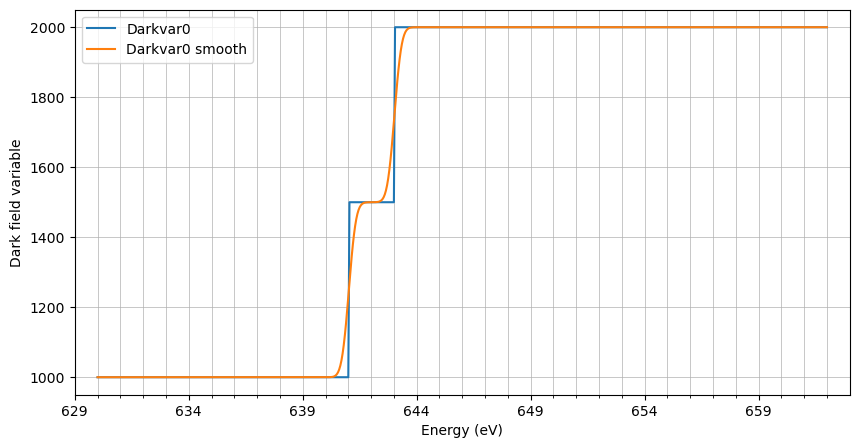

In [13]:
# print(len(energy))

# Check energy and index
print(energy[0])
print(energy[27])
print(energy[67])
print(energy[107])
print(energy[-1])

darkvar0_list = np.zeros(221, dtype=int)

# Assign values based on index ranges
darkvar0_list[0:68] = 1000
darkvar0_list[68:108] = 1500
darkvar0_list[108:] = 2000

darkvar0_list_smooth = filters.gaussian(darkvar0_list, sigma=5, preserve_range=True)

plt.figure(figsize=(10,5))
plt.plot(energy, darkvar0_list, label='Darkvar0')
plt.plot(energy, darkvar0_list_smooth, label='Darkvar0 smooth')

ax = plt.gca()  # Get the current axes
ax.grid(True, which='both', linewidth=0.5)  # Add grid
# plt.title("Intensity Profile Along Selected Line")
plt.xlabel('Energy (eV)')
plt.ylabel('Dark field variable')
# plt.title('')
plt.legend()

major_ticks = np.arange(629.0, 663.0, 5)
minor_ticks = np.arange(629.0, 663.0, 1)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
# ax.set_yticks(major_ticks)
# ax.set_yticks(minor_ticks, minor=True)

ax.set_xlim(629.0, 663.0)
# ax.set_ylim(-0.3, 0.6)

plt.show()

## Calculate XMCD

In [15]:
image0 = I_lcp
image1 = I_rcp

norm_image_lcp = []
norm_image_rcp = []
norm_dimage_lcp = []
norm_dimage_rcp = []

image_xmcd = []
dark_image_xmcd = []

dark1 = 1000
# dark1 = var0_ini

# best_darkvar0 = np.full(len(energy), 0) # Constant values
best_darkvar0 = darkvar0_list_smooth # Manual setting
# best_darkvar0 = best_darkvar0 # Automatic setting

for i, dark0 in enumerate(best_darkvar0):
# for i, dark0 in enumerate(blur):
    # print(dark0, dark1)
    # Extract the energy slice
    slice0 = image0[i, :]
    slice1 = image1[i, :]
        
    # Extract air region
    window_length = 5
    air0 = slice0[air_x0:air_x1]
    air0 = smooth_signal(air0,window_length,window_length-1)
    air1 = slice1[air_x0:air_x1]
    air1 = smooth_signal(air1,window_length,window_length-1)
        
    # Compute mean intensity in the air region
    airvar0 = np.mean(air0)
    airvar1 = np.mean(air1)
        
    # Dark field correction and normalization
    dslice0 = (slice0 - dark0) / ((airvar0 - dark0))
    norm_dslice0 = dslice0# / (np.mean(dslice0[air_x0:air_x1]))
    norm_slice0 = slice0 / airvar0

    dslice1 = (slice1 - dark1) / ((airvar1 - dark1))
    norm_dslice1 = dslice1# / (np.mean(dslice1[air_x0:air_x1]))
    norm_slice1 = slice1 / airvar1

    # XMCD Calculation
    # slice_xmcd = 100 * (slice0 - slice1) / (slice0 + slice1)
    # dark_slice_xmcd = 100 * (norm_dslice0 - norm_dslice1) / (norm_dslice0 + norm_dslice1)
    slice_xmcd = 100 * (norm_slice0 - norm_slice1)
    dark_slice_xmcd = 100 * (norm_dslice0 - norm_dslice1)

    # norm_dimage_lcp.append(dslice0)
    # norm_dimage_rcp.append(dslice1)
    norm_image_lcp.append(norm_slice0)
    norm_image_rcp.append(norm_slice1)
    norm_dimage_lcp.append(norm_dslice0)
    norm_dimage_rcp.append(norm_dslice1)
    
    image_xmcd.append(slice_xmcd)
    dark_image_xmcd.append(dark_slice_xmcd)

norm_image_lcp = np.array(norm_image_lcp)  # Shape: (energy_steps, pixels)
norm_image_rcp = np.array(norm_image_rcp)
norm_dimage_lcp = np.array(norm_dimage_lcp)  # Shape: (energy_steps, pixels)
norm_dimage_rcp = np.array(norm_dimage_rcp)
image_xmcd = np.array(image_xmcd)
dark_image_xmcd = np.array(dark_image_xmcd)

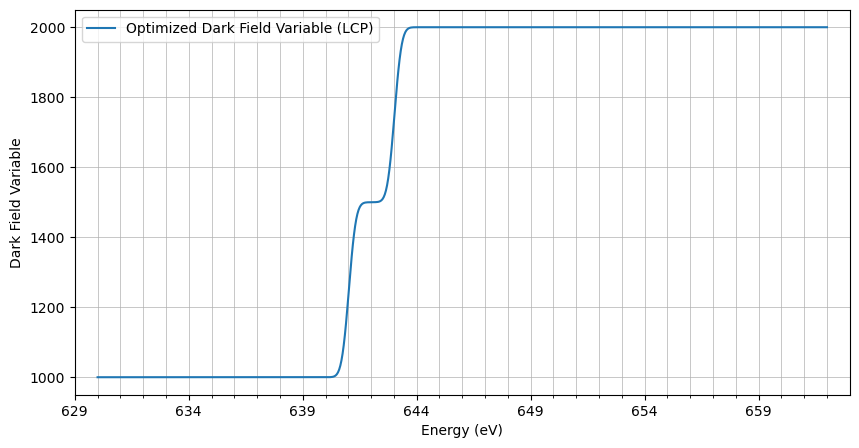

In [17]:
# blur = filters.gaussian(best_darkvar0, sigma=1)

plt.figure(figsize=(10,5))
plt.plot(energy, best_darkvar0, label='Optimized Dark Field Variable (LCP)')#, marker='o')
# plt.plot(energy, blur, label='Fitting')#, marker='o')
# plt.plot(energy, best_air_xmcd, label='Intensity of Air')#, marker='o')

ax = plt.gca()  # Get the current axes
ax.grid(True, which='both', linewidth=0.5)  # Add grid
# plt.title("Intensity Profile Along Selected Line")
plt.xlabel('Energy (eV)')
plt.ylabel('Dark Field Variable')
# plt.ylabel('XMCD (%)')
plt.legend()

major_ticks = np.arange(629.0, 663.0, 5)
minor_ticks = np.arange(629.0, 663.0, 1)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
# ax.set_yticks(major_ticks)
# ax.set_yticks(minor_ticks, minor=True)

ax.set_xlim(629.0, 663.0)
# ax.set_ylim(0.07, 0.1)

plt.show()
plt.show()

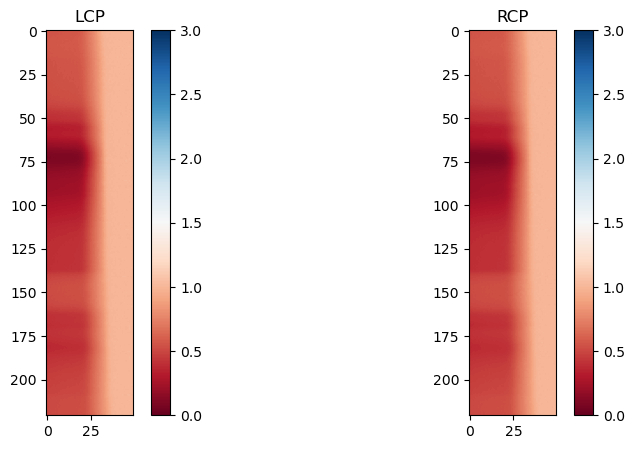

In [18]:
fig,(ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

#
im1=ax1.imshow(norm_dimage_lcp, cmap='RdBu', vmin=0, vmax=3)
ax1.set_title('LCP')
plt.colorbar(im1,ax=ax1)
#
im2=ax2.imshow(norm_dimage_rcp, cmap='RdBu', vmin=0, vmax=3)
ax2.set_title('RCP')
plt.colorbar(im2,ax=ax2)

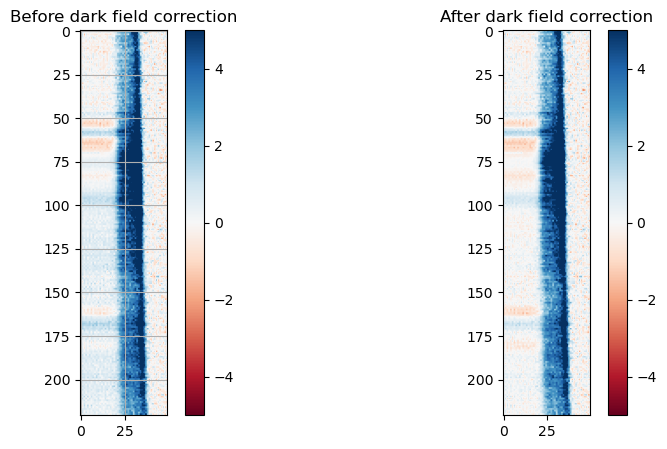

In [19]:
fig,(ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

#
im1=ax1.imshow(image_xmcd, cmap='RdBu', vmin=-5, vmax=5)
ax1.set_title('Before dark field correction')
plt.colorbar(im1,ax=ax1)
ax1.grid()
#
im2=ax2.imshow(dark_image_xmcd, cmap='RdBu', vmin=-5, vmax=5)
ax2.set_title('After dark field correction')
plt.colorbar(im2,ax=ax2)

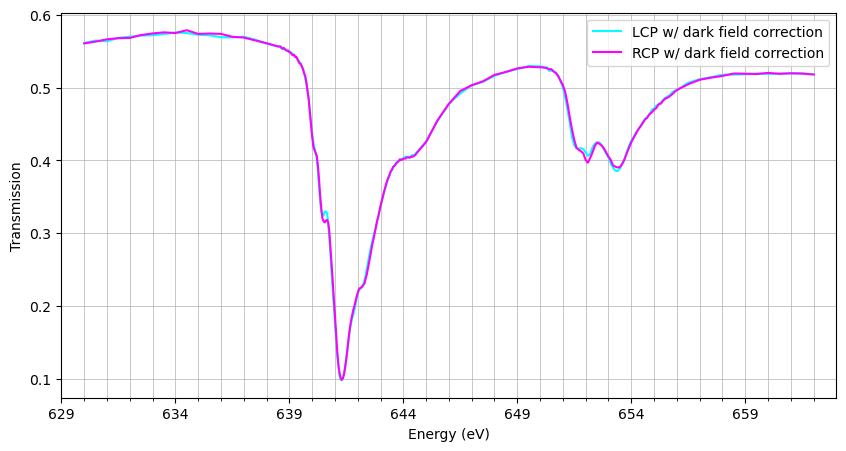

In [61]:
x0 = 5
x1 = 15

# Extract intensity values along the line

raw_transmission_lcp_line = np.mean(I_lcp[:, x0:x1], axis=1)
raw_transmission_rcp_line = np.mean(I_rcp[:, x0:x1], axis=1)

transmission_lcp_line = np.mean(norm_image_lcp[:, x0:x1], axis=1)
transmission_rcp_line = np.mean(norm_image_rcp[:, x0:x1], axis=1)

dark_transmission_lcp_line = np.mean(norm_dimage_lcp[:, x0:x1], axis=1)
dark_transmission_rcp_line = np.mean(norm_dimage_rcp[:, x0:x1], axis=1)


# Plot the intensity profile
plt.subplots(figsize=(10, 5))

# plt.plot(energy, raw_transmission_lcp_line, color='blue', marker='o', label='LCP Raw')
# plt.plot(energy, raw_transmission_rcp_line, color='orange', marker='o', label='RCP Raw')
# plt.plot(energy, transmission_lcp_line, color='blue', marker='o', label='LCP norm')
# plt.plot(energy, transmission_rcp_line, color='orange', marker='o', label='RCP norm')
plt.plot(energy, dark_transmission_lcp_line, color='cyan', label='LCP w/ dark field correction')
plt.plot(energy, dark_transmission_rcp_line, color='magenta', label='RCP w/ dark field correction')

ax = plt.gca()  # Get the current axes
ax.grid(True, which='both', linewidth=0.5)  # Add grid
# plt.title("Intensity Profile Along Selected Line")
plt.xlabel('Energy (eV)')
plt.ylabel('Transmission')
# plt.ylabel('XMCD (%)')
plt.legend()

major_ticks = np.arange(629.0, 663.0, 5)
minor_ticks = np.arange(629.0, 663.0, 1)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
# ax.set_yticks(major_ticks)
# ax.set_yticks(minor_ticks, minor=True)

ax.set_xlim(629.0, 663.0)
# ax.set_ylim(-0.3, 0.6)

plt.show()

### Get Amax

In [24]:
# # Check energy and index
print(energy[0])
print(energy[16])
print(energy[212])
print(energy[-1])

630.0
638.0
658.0
662.0


In [28]:
# Define the baseline regions (630 < E < 638 eV & 658 < E < 662 eV)
baseline_prel3_lcp = np.mean(dark_transmission_lcp_line[0:16]) 
baseline_postl2_lcp = np.mean(dark_transmission_lcp_line[212:-1])

baseline_prel3_rcp = np.mean(dark_transmission_rcp_line[0:16]) 
baseline_postl2_rcp = np.mean(dark_transmission_rcp_line[212:-1]) 

abs_peak_lcp = np.min(dark_transmission_lcp_line)
abs_peak_rcp = np.min(dark_transmission_rcp_line)

print(f"LCP Baseline for pre L3 edge (average intensity in 630 < E < 638 eV): {baseline_prel3_lcp:.4f}")
print(f"RCP Baseline for pre L3 edge (average intensity in 630 < E < 638 eV): {baseline_prel3_rcp:.4f}")
print(f"LCP Baseline for post L2 edge (average intensity in 658 < E < 662 eV): {baseline_postl2_lcp:.4f}")
print(f"RCP Baseline for post L2 edge (average intensity in 658 < E < 662 eV): {baseline_postl2_rcp:.4f}")
print(f"LCP absorption peak: {abs_peak_lcp:.4f}")
print(f"RCP absorption peak: {abs_peak_rcp:.4f}")

LCP Baseline for pre L3 edge (average intensity in 630 < E < 638 eV): 0.5696
RCP Baseline for pre L3 edge (average intensity in 630 < E < 638 eV): 0.5704
LCP Baseline for post L2 edge (average intensity in 658 < E < 662 eV): 0.5187
RCP Baseline for post L2 edge (average intensity in 658 < E < 662 eV): 0.5188
LCP absorption peak: 0.0977
RCP absorption peak: 0.0983


In [31]:
amax_lcp = baseline_prel3_lcp - abs_peak_lcp
amax_rcp = baseline_prel3_rcp - abs_peak_rcp
print(f"LCP Amax: {amax_lcp:.4f}")
print(f"RCP Amax: {amax_rcp:.4f}")

amax = 0.472

LCP Amax: 0.4719
RCP Amax: 0.4721


In [36]:
# xmcd_line = np.mean(image_xmcd[:, x0:x1], axis=1)
# dark_xmcd_line = np.mean(dark_image_xmcd[:, x0:x1], axis=1)

# xmcd_line = 100 * (transmission_lcp_line - transmission_rcp_line) / (transmission_lcp_line + transmission_rcp_line)
# dark_xmcd_line = 100 * (dark_transmission_lcp_line - dark_transmission_rcp_line) / (dark_transmission_lcp_line + dark_transmission_rcp_line)

xmcd_line = 100 * (transmission_lcp_line - transmission_rcp_line) / amax
dark_xmcd_line = 100 * (dark_transmission_lcp_line - dark_transmission_rcp_line) / amax

xmcd_line_smooth = filters.gaussian(xmcd_line, sigma=1, preserve_range=True)
dark_xmcd_line_smooth = filters.gaussian(dark_xmcd_line, sigma=1, preserve_range=True)

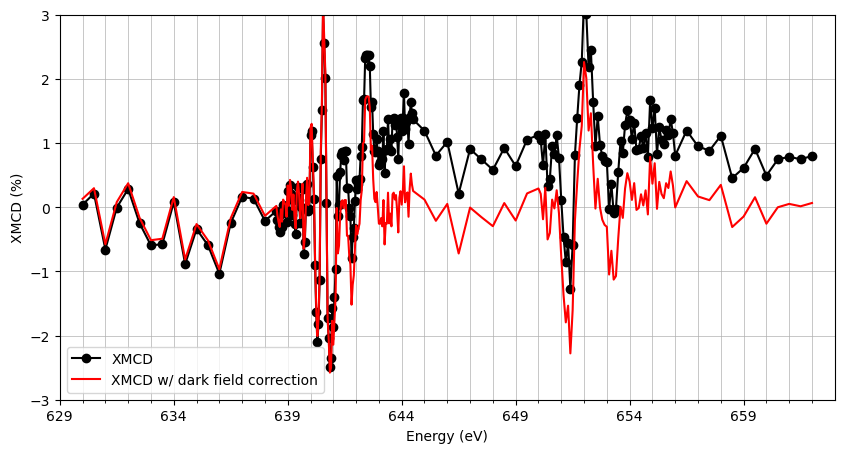

In [54]:
# Plot the intensity profile
plt.subplots(figsize=(10, 5))

plt.plot(energy, xmcd_line, color='black', marker='o', label='XMCD')
# plt.plot(energy, xmcd_line_smooth, color='gray', label='XMCD smooth')
# plt.plot(energy, dark_xmcd_line, color='red', marker='o', label='XMCD w/ dark field correction')
plt.plot(energy, dark_xmcd_line, color='red', label='XMCD w/ dark field correction')
# plt.plot(energy, dark_xmcd_line_smooth, color='red', label='XMCD w/ dark field correction smooth')

ax = plt.gca()  # Get the current axes
ax.grid(True, which='both', linewidth=0.5)  # Add grid
# plt.title("Intensity Profile Along Selected Line")
plt.xlabel('Energy (eV)')
# plt.ylabel('Transmission')
plt.ylabel('XMCD (%)')
plt.legend()

major_ticks = np.arange(629.0, 663.0, 5)
minor_ticks = np.arange(629.0, 663.0, 1)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
# ax.set_yticks(major_ticks)
# ax.set_yticks(minor_ticks, minor=True)

ax.set_xlim(629.0, 663.0)
ax.set_ylim(-3, 3)

plt.show()

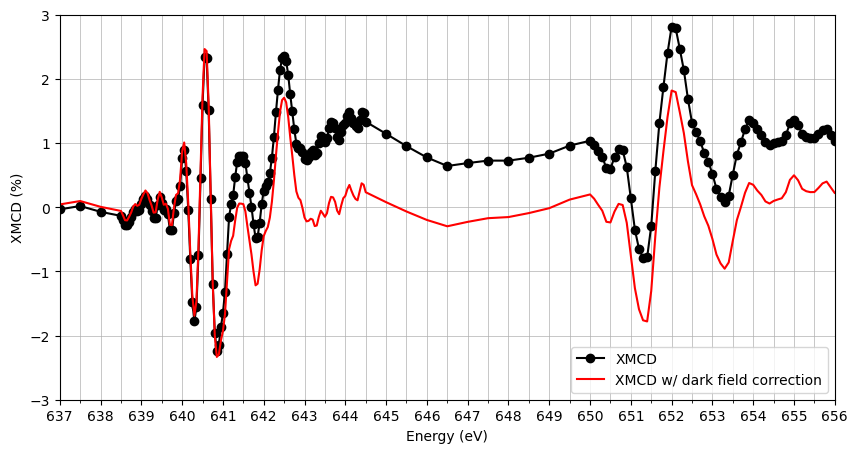

In [55]:
# Plot the intensity profile
plt.subplots(figsize=(10, 5))

plt.plot(energy, xmcd_line_smooth, color='black', marker='o', label='XMCD')
plt.plot(energy, dark_xmcd_line_smooth, color='red', label='XMCD w/ dark field correction')

ax = plt.gca()  # Get the current axes
ax.grid(True, which='both', linewidth=0.5)  # Add grid
# plt.title("Intensity Profile Along Selected Line")
plt.xlabel('Energy (eV)')
# plt.ylabel('Transmission')
plt.ylabel('XMCD (%)')
plt.legend()

major_ticks = np.arange(629.0, 663.0, 1)
minor_ticks = np.arange(629.0, 663.0, 0.5)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
# ax.set_yticks(major_ticks)
# ax.set_yticks(minor_ticks, minor=True)

ax.set_xlim(637.0, 656.0)
ax.set_ylim(-3, 3)

plt.show()

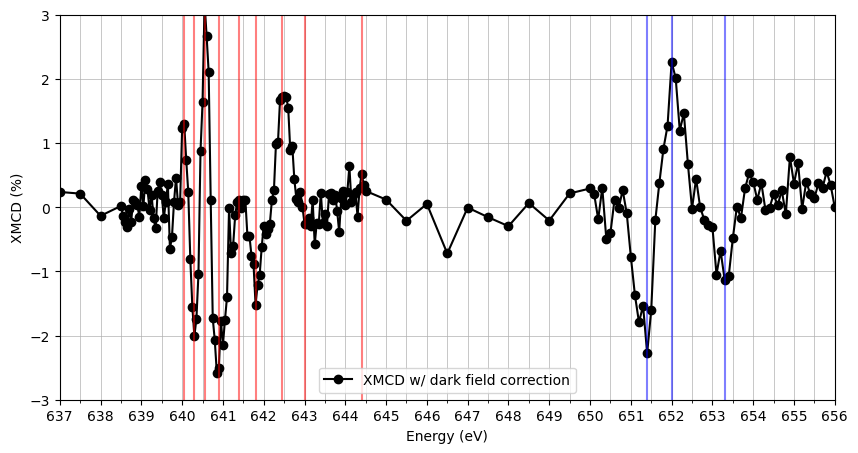

In [41]:
# Plot the intensity profile
plt.subplots(figsize=(10, 5))

# plt.plot(energy, xmcd_line, color='blue', marker='o', label='XMCD')
plt.plot(energy, dark_xmcd_line, color='black', marker='o', label='XMCD w/ dark field correction')

plt.axvline(640.05, color='red', alpha=0.5)
plt.axvline(640.30, color='red', alpha=0.5)
plt.axvline(640.55, color='red', alpha=0.5)
plt.axvline(640.90, color='red', alpha=0.5)
plt.axvline(641.40, color='red', alpha=0.5)
plt.axvline(641.80, color='red', alpha=0.5)
plt.axvline(642.45, color='red', alpha=0.5)
plt.axvline(643.00, color='red', alpha=0.5)
plt.axvline(644.40, color='red', alpha=0.5)

plt.axvline(651.4, color='blue', alpha=0.5)
plt.axvline(652.0, color='blue', alpha=0.5)
plt.axvline(653.3, color='blue', alpha=0.5)

ax = plt.gca()  # Get the current axes
ax.grid(True, which='both', linewidth=0.5)  # Add grid
# plt.title("Intensity Profile Along Selected Line")
plt.xlabel('Energy (eV)')
# plt.ylabel('Transmission')
plt.ylabel('XMCD (%)')
plt.legend()

major_ticks = np.arange(629.0, 663.0, 1)
minor_ticks = np.arange(629.0, 663.0, 0.5)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
# ax.set_yticks(major_ticks)
# ax.set_yticks(minor_ticks, minor=True)

ax.set_xlim(637.0, 656.0)
ax.set_ylim(-3, 3)

plt.show()

# Save data

In [42]:
save_path = ''
print(save_path)

C:/Users/yamamoto/Dropbox/MPI/Project/MnTe/Beamtime/BESSY_MAXYMUS_Jan2025/Analyzed/Spectra/


In [43]:
fname = 'energy_line'

line_npy = save_path + fname + '.txt'
np.savetxt(line_npy, energy, fmt="%.4f")

In [44]:
fname = 'dark_transmission_lcp_line'

line_npy = save_path + fname + '.txt'
np.savetxt(line_npy, dark_transmission_lcp_line, fmt="%.4f")

In [45]:
fname = 'dark_transmission_rcp_line'

line_npy = save_path + fname + '.txt'
np.savetxt(line_npy, dark_transmission_rcp_line, fmt="%.4f")

In [46]:
fname = 'xmcd_line'

line_npy = save_path + fname + '.txt'
np.savetxt(line_npy, xmcd_line, fmt="%.4f")

In [47]:
fname = 'dark_xmcd_line'

line_npy = save_path + fname + '.txt'
np.savetxt(line_npy, dark_xmcd_line, fmt="%.4f")

In [49]:
fname = 'darkvar0_smooth'

line_npy = save_path + fname + '.txt'
np.savetxt(line_npy, darkvar0_list_smooth, fmt="%.4f")